# Image generation with Stable Diffusion v3 and OpenVINO

Stable Diffusion V3 is next generation of latent diffusion image Stable Diffusion models family that outperforms state-of-the-art text-to-image generation systems in typography and prompt adherence, based on human preference evaluations. In comparison with previous versions, it based on Multimodal Diffusion Transformer (MMDiT) text-to-image model that features greatly improved performance in image quality, typography, complex prompt understanding, and resource-efficiency.

![mmdit.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/dd079427-89f2-4d28-a10e-c80792d750bf)

More details about model can be found in [model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium), [research paper](https://stability.ai/news/stable-diffusion-3-research-paper) and [Stability.AI blog post](https://stability.ai/news/stable-diffusion-3-medium).

In this tutorial, we will consider how to convert Stable Diffusion v3 for running with OpenVINO. That notebook shows how to perform optimization with [NNCF](https://github.com/openvinotoolkit/nncf/).

If you want to run previous Stable Diffusion versions, please check our other notebooks:
* [Stable Diffusion](../stable-diffusion-text-to-image)
* [Stable Diffusion v2](../stable-diffusion-v2)
* [Stable Diffusion XL](../stable-diffusion-xl)
* [LCM Stable Diffusion](../latent-consistency-models-image-generation)
* [Turbo SDXL](../sdxl-turbo)
* [Turbo SD](../sketch-to-image-pix2pix-turbo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-v3/stable-diffusion-v3.ipynb" />

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Build PyTorch pipeline](#Build-PyTorch-pipeline)
- [Convert models with OpenVINO](#Convert-models-with-OpenVINO)
    - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
    - [Compress model weights](#Compress-model-weights)
- [Prepare OpenVINO inference pipeline](#Prepare-OpenVINO-inference-pipeline)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Interactive demo](#Interactive-demo)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform

%pip install -q "gradio>=4.19" "diffusers>=0.30.0" "torch>=2.1"  "transformers[sentencepiece]" "nncf>=2.12.0" "datasets>=2.14.6" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2025.0.0" "openvino-tokenizers" "openvino-genai"

if platform.system() == "Darwin":
    %pip install "numpy<2.0.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from pathlib import Path

if not Path("sd3_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/sd3_helper.py")
    open("sd3_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("stable-diffusion-v3.ipynb")

## Build PyTorch pipeline
[back to top ⬆️](#Table-of-contents:)

>**Note**: run model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit selected model card, e.g. [stabilityai/stable-diffusion-3-medium-diffusers](https://huggingface.co/stabilityai/stable-diffusion-3-medium-diffusers), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [3]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

We will use [Diffusers](https://huggingface.co/docs/diffusers/main/en/index) library integration for running Stable Diffusion v3 model. You can find more details in Diffusers [documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_3).
Additionally, we can apply optimization for pipeline performance and memory consumption:

* **Use turbo model version**. Turbo model variant is distilled using [Adversarial Diffusion Distillation (ADD)](https://stability.ai/research/adversarial-diffusion-distillation) approach. This features improved performance in image quality, typography, complex prompt understanding, and resource-efficiency, with a focus on fewer inference steps.
* **Remove T5 text encoder**. Removing the memory-intensive 4.7B parameter T5-XXL text encoder during inference can significantly decrease the memory requirements for SD3 with only a slight loss in performance. If you want to use this model in pipeline, please set **use t5 text encoder** checkbox.

In [4]:
from sd3_helper import get_pipeline_options

pt_pipeline_options, model_selector, load_t5, to_compress = get_pipeline_options()

display(pt_pipeline_options)

## Convert models with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) integration to `optimum-cli` tool for weight compression.


In [5]:
from cmd_helper import optimum_cli

model_id = model_selector.value
print(f"Selected {model_id} model")

base_model_path = Path(model_id.split("/")[-1])

model_path = base_model_path / ("FP16" if not to_compress.value else "INT4")

if not to_compress.value:
    additional_args = {"weight-format": "fp16"}
else:
    additional_args = {"weight-format": "int4", "group-size": "64", "ratio": "1.0"}


if not model_path.exists():
    optimum_cli(model_id, model_path)

Selected tensorart/stable-diffusion-3.5-medium-turbo model


## Prepare OpenVINO inference pipeline
[back to top ⬆️](#Table-of-contents:)

`openvino_genai.Text2ImagePipeline` represents inference pipeline for text-to-image generation. For creation pipeline instance, you should provide directory with converted to OpenVINO model and inference device.

In [6]:
import openvino_genai as ov_genai
from sd3_helper import init_pipeline_without_t5  # noqa: F401

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

In [7]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
if not load_t5.value:
    ov_pipe = init_pipeline_without_t5(model_path, device.value)
else:
    ov_pipe = ov_genai.Text2ImagePipeline(model_path, device.value)

In [9]:
from PIL import Image
from tqdm.notebook import tqdm
import sys
import os
import re
import time

num_inference_steps = 28 if "turbo" not in model_id else 8

pbar = tqdm(total=num_inference_steps)


def callback(step, num_steps, latent):
    if num_steps != pbar.total:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False
    
prompt = "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors"
start_time = time.time()
image_tensor = ov_pipe.generate(
    prompt = prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=5 if "turbo" not in model_id else 0.5,
    height=512,
    width=512,
    generator=ov_genai.TorchGenerator(141),
    callback=callback,
)
end_time = time.time()
latency = end_time - start_time
print(f"Image generation latency: {latency:.2f} seconds")
os.makedirs("/tmp/generated_images", exist_ok=True)

clean_prompt = re.sub(r'[^\w\-_\.]', '_', prompt)[:230]
image_path = f"/tmp/generated_images/{clean_prompt}.png"

image = Image.fromarray(image_tensor.data[0])
image.save(image_path)

  0%|          | 0/8 [00:00<?, ?it/s]

Image generation latency: 23.49 seconds


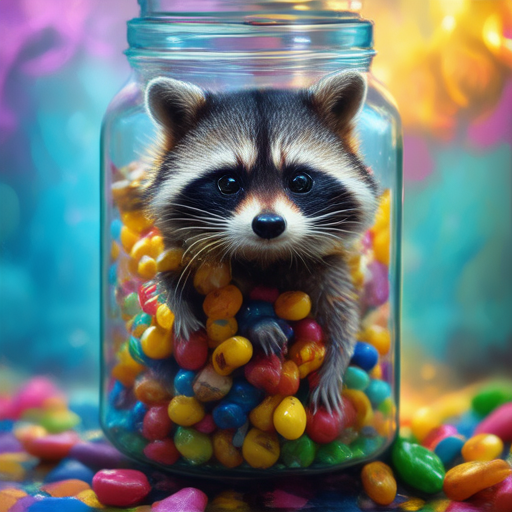

In [10]:
image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe, "turbo" in model_id)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
